## Shor Algorithm
---

**Microcredential:** Cryptography and Quantum Information  
**Period:** February 2026

---

### Abstract

This notebook provides an implementation of the **Shor Algorithm** using Qiskit. The project focuses on **the Order Finding Problem** to determine the prime factors of a composite integer $N$.

Components include:
* **Theoretical:** A mathematical breakdown of the exponential quantum speedup.
* **Dynamic Oracle:** Automated circuit generation for both constant and balanced functions.
* **Validation and Simulation:** Comprehensive testing using the **Aer** simulator to verify function types.

---

### Problem

Given a large composite integer $N \in \mathbb{Z}$ which is the product of two distinct prime numbers $p$ and $q$:

$$N = p \cdot q$$

While multiplying two prime numbers to find $N$ is trivial for classical computers, the reverse operation is practically impossible for large values.


**The Classical Approach**

Classical algorithms to solve this problem,require sub-exponential time. The time required to locate these factors grows rapidly that it would take billions of years to crack a 2048-bit key. This is because classical computers must "guess and check" through a huge space of possible factors.

**Classical Complexity:**
$$\mathcal{O}\left(e^{n^{1/3}}\right)$$

*Where $n$ denotes the bit-length of the integer $N$. This represents **sub-exponential** growth.*

**The Shor’s Quantum Approach**

Shor's Algorithm solves this problem using quantum computation in **polynomial time**. It transforms a brute-force problem into a **period-finding problem** using modular arithmetic. By exploiting quantum superposition and interference, we can identify the period $r$ of the following function:

$$f(x) = a^x \pmod N$$



Once $r$ is found, the prime factors are extracted via a simple classical calculation.

**Quantum Complexity:**
$$\mathcal{O}\left(n^3\right)$$

*Where $n$ denotes the bit-length of the integer $N$. This represents **polynomial** growth.*

**Mathematical Constraints**

To ensure the algorithm's convergence, the chosen base $a$ must satisfy:

$$\text{gcd}(a, N) = 1$$

*This condition ensures that $a$ and $N$ are coprime, allowing the existence of a well-defined period $r$ in the modular group.*


In [ ]:
from IPython.display import clear_output

!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

clear_output()
print("All dependencies installed successfully. Environment ready.")

All dependencies installed successfully. Environment ready.


In [ ]:
import math
from fractions import Fraction
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

### Quantum Register Allocation and State Initialization

First, we define the basics part of the quantum circuit. The system is partitioned into two distinct functional registers to facilitate the **Quantum Phase Estimation (QPE)**:

1.  **Phase Register (Counting Qubits):** A set of 8 qubits initialized in a uniform superposition using **Hadamard (H) gates**. The register acts as our digital "clock" to resolve the phase $\theta = s/r$ with high precision.

2.  **Eigenstate Register (Target Qubits):** A 4-qubit register that holds the physical states of our modular function.


**State Preparation:**
The system starts in the ground state $|0\rangle^{\otimes n}$. To perform the order-finding algorithm, we apply an **X gate** to the first qubit of the **eigenstate_register**. This shifts the state from $|0000\rangle$ to $|0001\rangle$ (the decimal $|1\rangle$), which represents the multiplicative identity in the modular group.

In [ ]:
modulus_n = 15
base_a = 7
counting_qubits = 8
target_qubits = 4

phase_register = QuantumRegister(counting_qubits, 'ph')
eigenstate_register = QuantumRegister(target_qubits, 'eig')
classical_readout = ClassicalRegister(counting_qubits, 'measurement')
circuit = QuantumCircuit(phase_register, eigenstate_register, classical_readout)

circuit.h(phase_register)
circuit.x(eigenstate_register[0])


### Unitary Evolution and Modular Exponentiation

We implement the core quantum operation of the algorithm: the controlled-unitary evolution. Mathematically, we are mapping the classical function $f(x) = a^x \pmod N$ in the **Hilbert space** of system.

The objective is to encode the periodicity of the modular group into the relative phases of **phase_register**. Since we are using $a=7$ and $N=15$, the operator $U$ acts as a permutation matrix on the computational basis of the **eigenstate_register**.


A critical optimization is applied: $7^4 \equiv 1 \pmod{15}$, the unitary operator $U^{2^k}$ collapses to the **identity matrix** $\mathcal{I}$ for all $k \ge 2$. By excluding these identity operations, we drastically reduce the gate count and the cumulative incoherent noise.

In [ ]:
def c_unitary_pow1(circuit, control, target):
    circuit.cswap(control, target[1], target[2])
    circuit.cswap(control, target[2], target[3])
    circuit.cswap(control, target[0], target[3])

def c_unitary_pow2(circuit, control, target):
    circuit.cswap(control, target[1], target[3])
    circuit.cswap(control, target[0], target[2])

c_unitary_pow1(circuit, phase_register[0], eigenstate_register)
c_unitary_pow2 (circuit, phase_register[1], eigenstate_register)

/tmp/ipython-input-786163974.py:1: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  inverse_qft = QFT(num_qubits=counting_qubits, approximation_degree=0, do_swaps=True, inverse=True, name="IQFT")


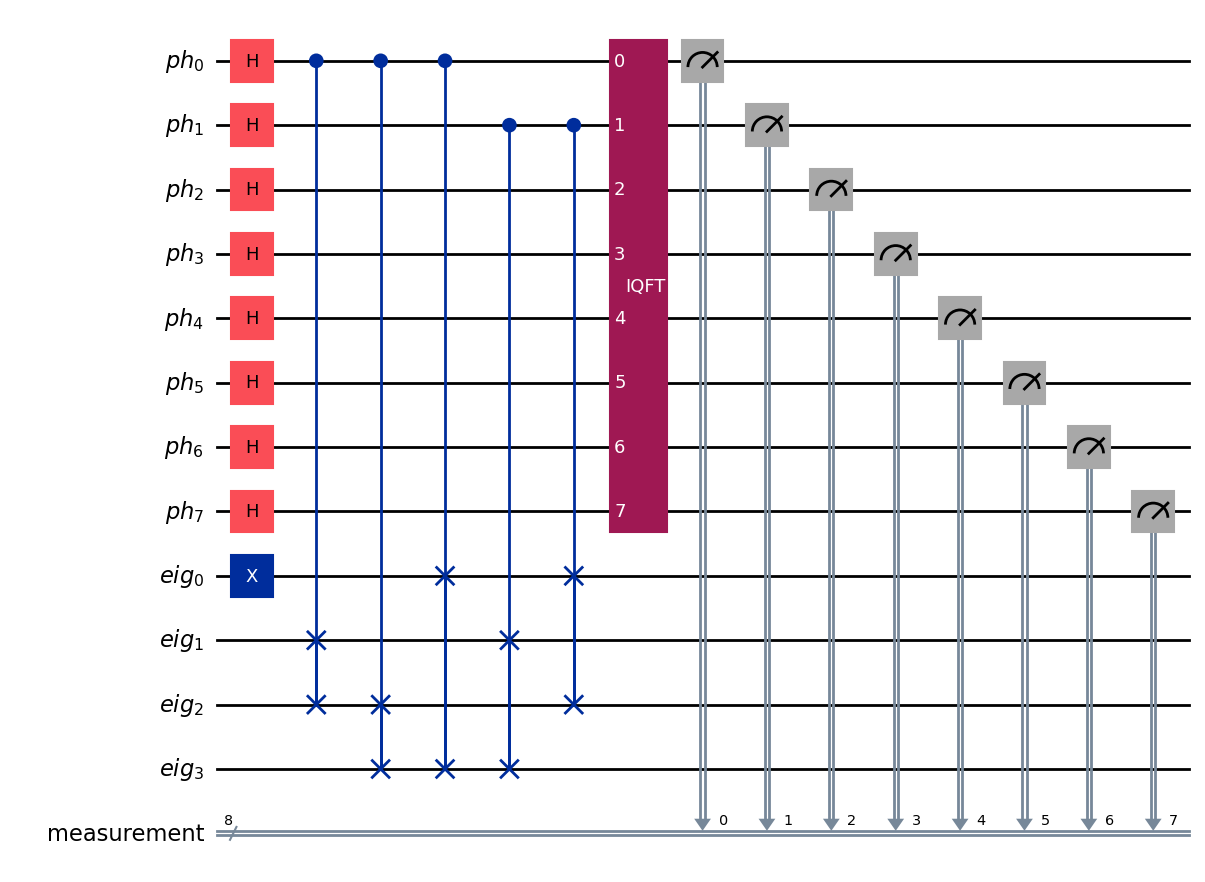

In [ ]:
inverse_qft = QFT(num_qubits=counting_qubits, approximation_degree=0, do_swaps=True, inverse=True, name="IQFT")
circuit.append(inverse_qft, phase_register)

circuit.measure(phase_register, classical_readout)

circuit.draw(output='mpl', fold=-1, style='iqp')

In [ ]:
simulation = AerSimulator()
compiled_circuit = transpile(circuit, simulation, optimization_level=3)
execution = simulation.run(compiled_circuit, shots=2048)
measurement_distribution = execution.result().get_counts()

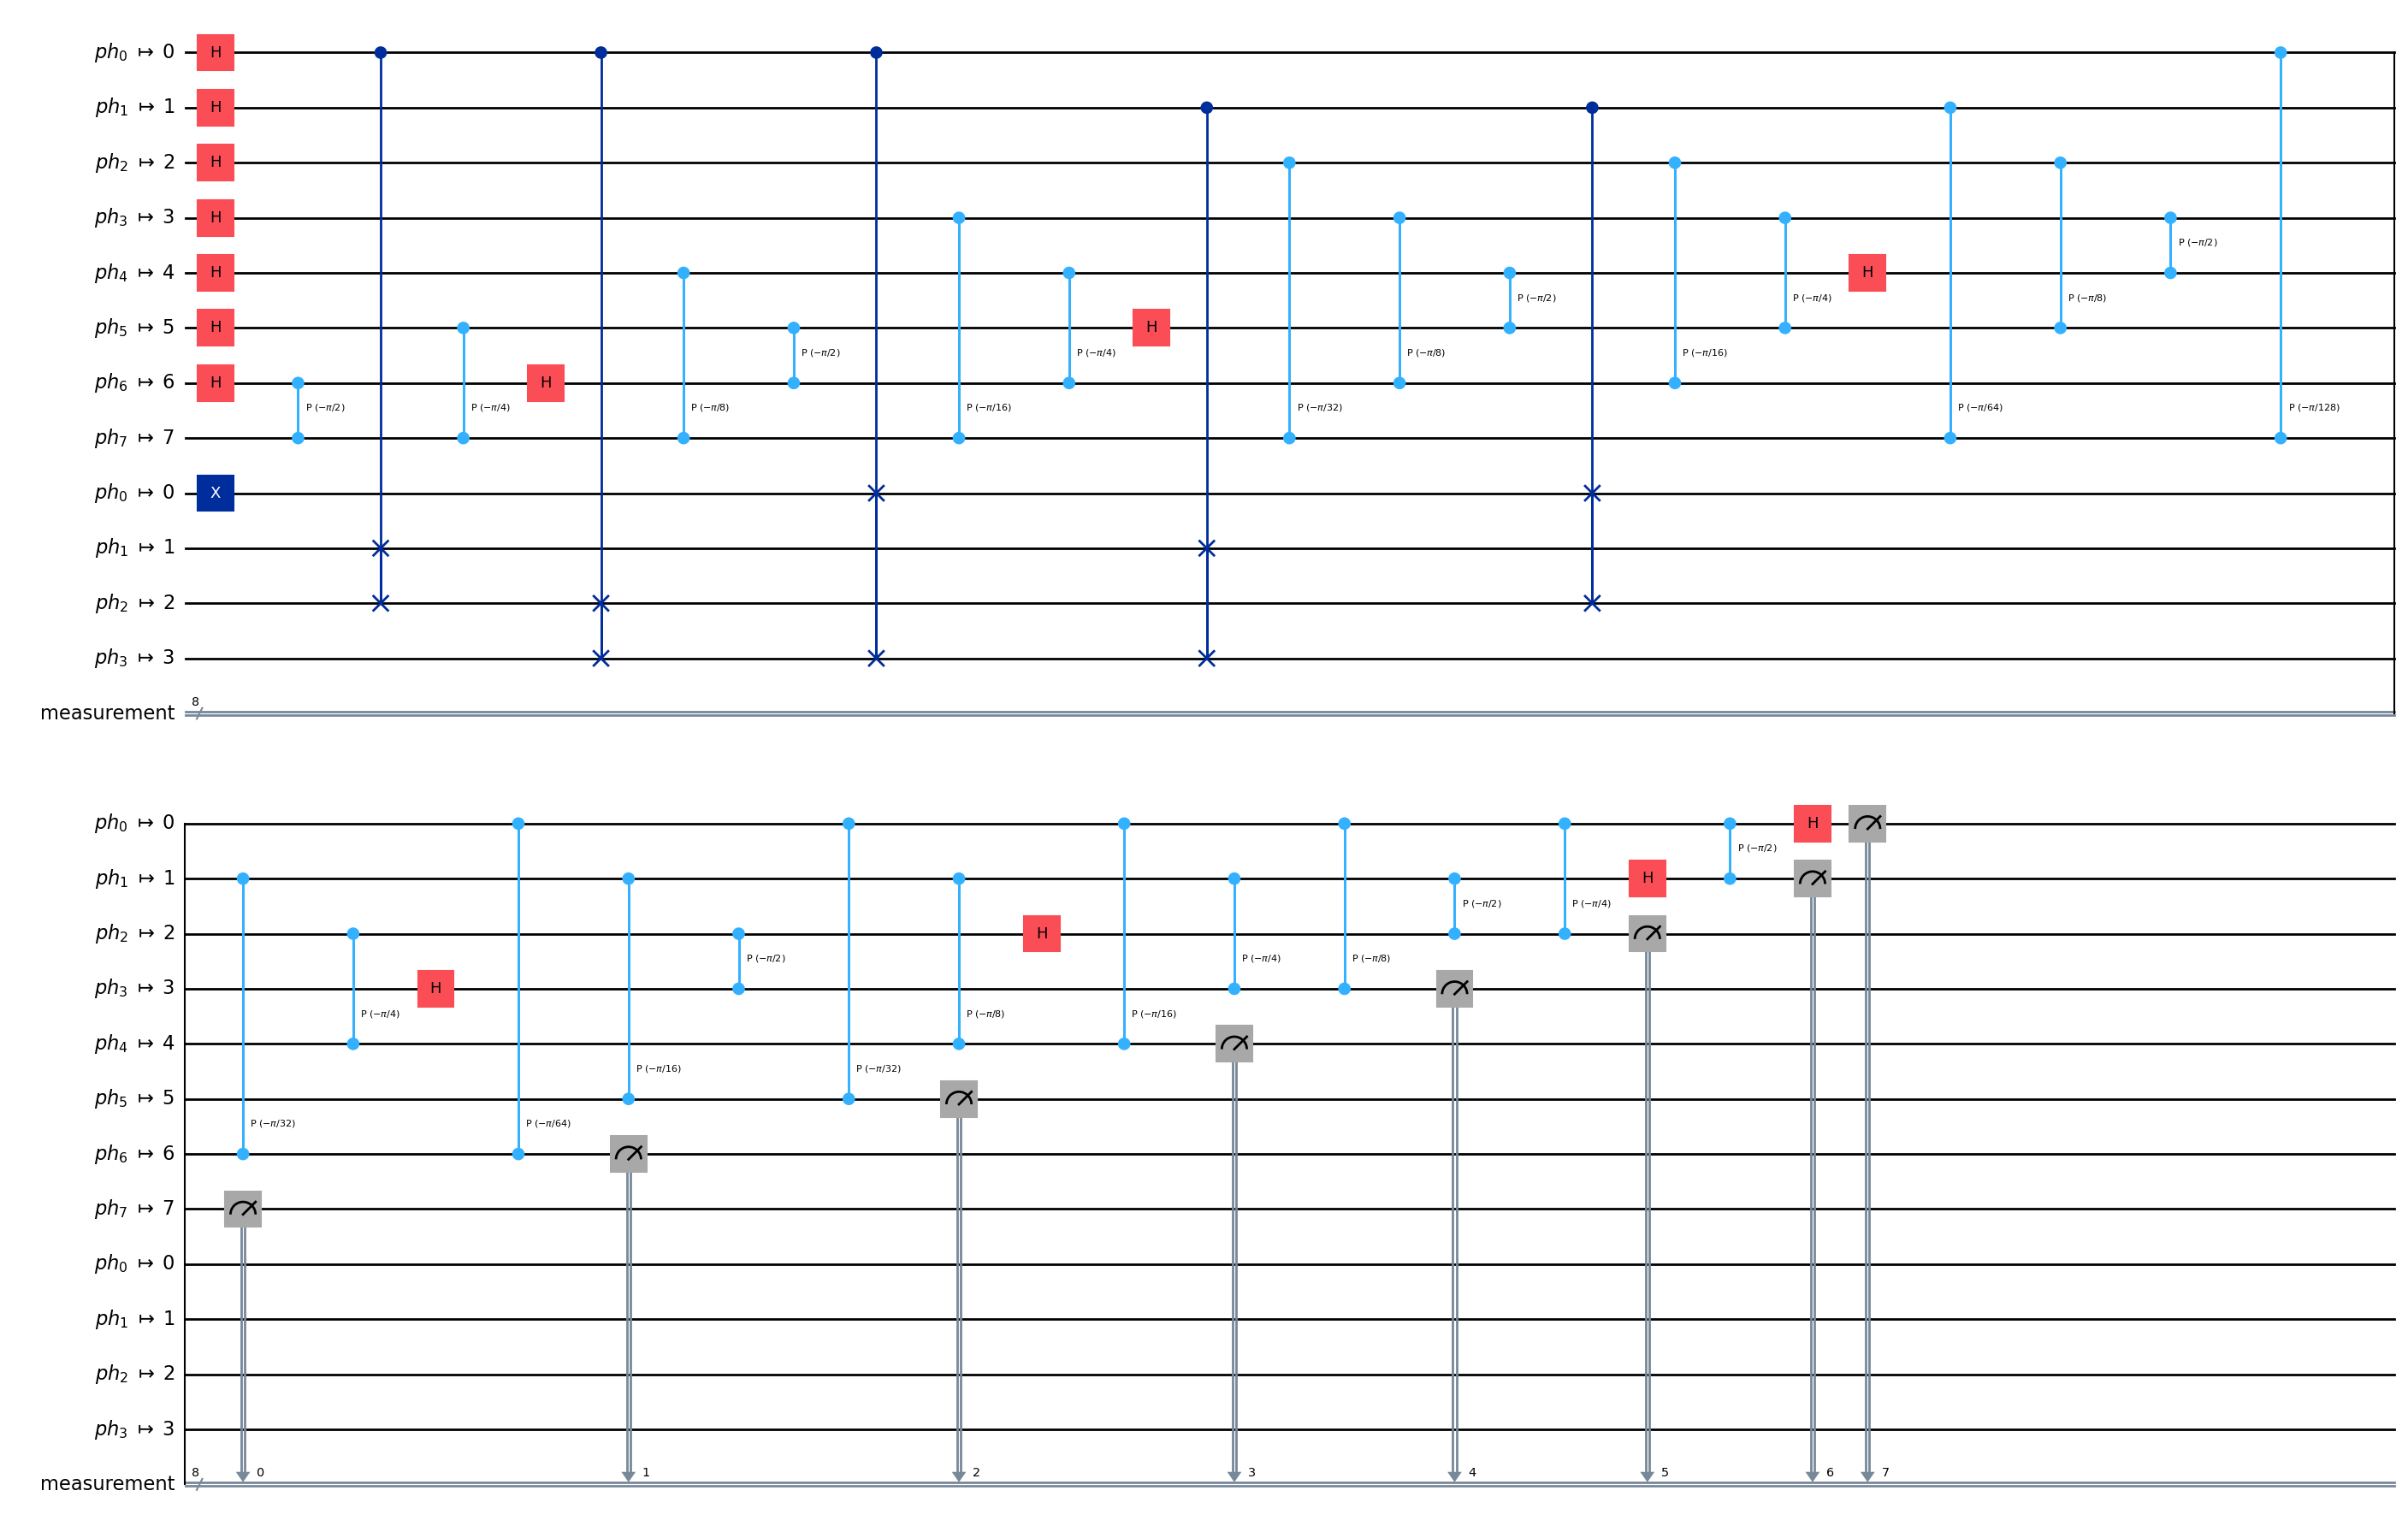

In [ ]:
compiled_circuit.draw(output='mpl', idle_wires=False, fold=40)

In [ ]:
prime_factors = set()

for measured_state, frequency in measurement_distribution.items():
    state_decimal_value = int(measured_state, 2)
    if state_decimal_value == 0:
        continue

    estimated_phase = state_decimal_value / (2**counting_qubits)
    continued_fraction = Fraction(estimated_phase).limit_denominator(modulus_n)
    estimated_period = continued_fraction.denominator

    if estimated_period % 2 == 0:
        half_period = estimated_period // 2
        modular_exponentiation_eval = pow(base_a, half_period, modulus_n)

        if modular_exponentiation_eval != modulus_n - 1:
            p_factor = math.gcd(modular_exponentiation_eval - 1, modulus_n)
            q_factor = math.gcd(modular_exponentiation_eval + 1, modulus_n)

            if p_factor not in [1, modulus_n]:
                prime_factors.add(p_factor)
            if q_factor not in [1, modulus_n]:
                prime_factors.add(q_factor)

print(f"Computed Prime Factors for N={modulus_n}: {prime_factors}")

Computed Prime Factors for N=15: {3, 5}


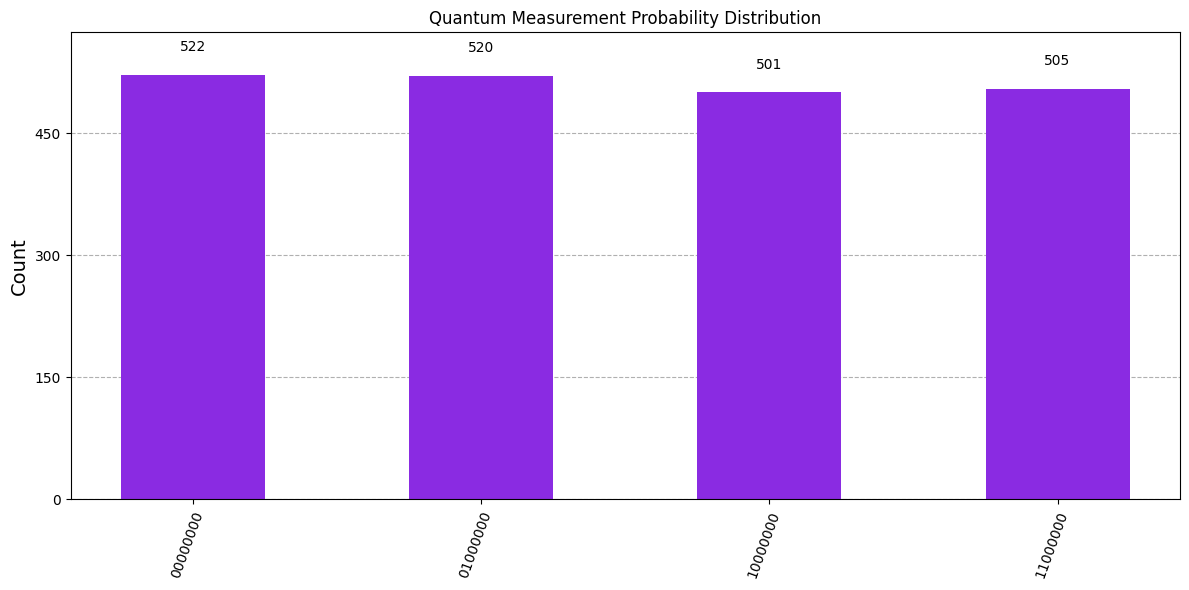

In [ ]:
plot_histogram(measurement_distribution, title="Quantum Measurement Probability Distribution", figsize=(12, 6), color='#8A2BE2')